In [1]:
from google.colab import drive
drive.mount('/content/drive')


## imports

import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

Mounted at /content/drive


In [2]:
data = pd.read_csv("/content/drive/My Drive/Vayuh_assignment/dataset/dataset_training_15Yr.csv")
data.head()


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,lat,lon,tmp2m
0,1044100,2004-07-06,0.285847,-0.227877,-0.966594,-0.138245,-0.024113,-1.337076,1.344408,0.276340,2.357603,-0.499968,-0.497430,-0.720335,1.238926,0.285205,-2.544513,0.43,0.017,1,2.702671,-0.6,0.1,-0.2,-1.3,27.25,261.75,29.814835
1,1044297,2004-07-07,0.436369,-0.365566,-0.717703,-0.121839,0.117753,-1.155856,1.391621,-0.148625,1.073330,-0.347458,-0.455577,-0.682972,0.223345,0.828101,-1.475737,0.43,-0.180,1,2.824950,-0.5,0.5,0.2,-1.2,27.25,261.75,29.895765
2,1044494,2004-07-08,0.447267,-0.523955,-0.682623,-0.106435,0.165743,-1.192861,1.773909,0.350742,-0.142775,-0.113653,-0.305307,-0.385678,-0.670674,0.861823,-1.752775,0.43,-0.246,1,2.666017,-0.5,0.5,0.2,-1.2,27.25,261.75,29.970346
3,1044691,2004-07-09,0.491929,-0.502293,-0.610014,-0.067906,0.297197,-1.223705,1.361836,0.294435,-0.520425,0.020780,-0.201393,-0.352330,-0.440481,0.813571,-1.277245,0.43,-0.176,1,2.528744,-0.5,0.5,0.2,-1.2,27.25,261.75,30.070539
4,1044888,2004-07-10,0.623222,-0.371508,-0.484439,-0.193691,0.092769,-0.847167,0.504504,0.355570,-0.663742,0.159503,-0.076510,-0.141143,-0.085695,0.685330,-0.946408,0.43,-0.364,1,2.515503,-0.5,0.5,0.2,-1.2,27.25,261.75,30.143854


In [3]:
"""
A method to create X and Y matrix from a time series array for the training of 
deep learning models 

The lag I have taken is 14 days, so the temp prediction done on day X will have previous 13 values + X's values to predict Y (Avg temp over 2 weeks, 2 weeks from X)   

"""
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            # print(Y)
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [4]:
# Number of lags (hours back) to use for models
lag = 14
# Steps ahead to forecast 
n_ahead = 1
# Share of obs in testing 
test_share = 0.1
# Epochs for training
epochs = 40
# Batch size 
batch_size = 256
# Learning rate
lr = 0.001
# Number of neurons in LSTM layer
n_layer = 64
# The features used in the modeling 
features_final = ['tmp2m','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', 'lat',
       'lon']

In [5]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 

        lstm_layer1 = LSTM(n_layer,return_sequences=True,activation="relu")(lstm_input)
        
        lstm_layer2 = LSTM(n_layer, activation='relu')(lstm_layer1)

        x = Dense(n_outputs)(lstm_layer2)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [7]:
# Subseting only the needed columns 
ts = data[features_final]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1- test_share))]
test = ts[int(nrows * (1 - test_share)):]

train_mean = train.mean()
train_std = train.std()


train = (train - train_mean) / train_std
test = (test - train_mean) / train_std


# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [8]:
# Spliting into train and test sets 
Xtrain, Ytrain = (
    X[: int(X.shape[0] * (1 - test_share))],
    Y[: int(X.shape[0] * (1 - test_share))],
)

Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [9]:
# Initiating the model object
model = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=n_ahead,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch_size,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
history = model.train()

Epoch 1/40
3792/3792 [==============================] - 390s 102ms/step - loss: 0.1008 - val_loss: 0.0704
Epoch 2/40
3792/3792 [==============================] - 383s 101ms/step - loss: 0.0440 - val_loss: 0.0506
Epoch 3/40
3792/3792 [==============================] - 385s 102ms/step - loss: 0.0320 - val_loss: 0.0421
Epoch 4/40
3792/3792 [==============================] - 383s 101ms/step - loss: 0.0301 - val_loss: 0.0402
Epoch 5/40
3792/3792 [==============================] - 380s 100ms/step - loss: 0.0298 - val_loss: 0.0282
Epoch 6/40
3792/3792 [==============================] - 380s 100ms/step - loss: 0.0275 - val_loss: 0.0322
Epoch 7/40
3792/3792 [==============================] - 382s 101ms/step - loss: 0.0267 - val_loss: 0.0285
Epoch 8/40
3792/3792 [==============================] - 387s 102ms/step - loss: 0.0258 - val_loss: 0.0485
Epoch 9/40
3792/3792 [==============================] - 387s 102ms/step - loss: 0.0251 - val_loss: 0.0253
Epoch 10/40
3792/3792 [=======================

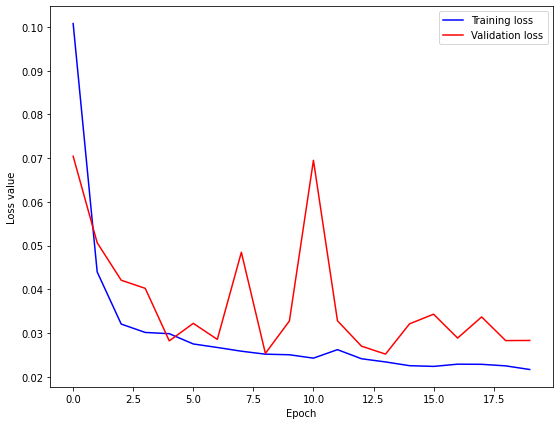

In [10]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [11]:
path='/content/drive/My Drive/Vayuh_assignment/DeepLearning/weights/'
# save
model.model.save_weights(path)
model.model.save("/content/drive/My Drive/Vayuh_assignment/DeepLearning/model.h5")